In [1]:
import scrapy
import scrapy.crawler as crawler
from scrapy.utils.log import configure_logging
from multiprocessing import Process, Queue
from twisted.internet import reactor
from collections import Counter
import logging
import json
import re
import os
import pandas as pd
import numpy as np
import gc
import copy

from tqdm.auto import tqdm

from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel
from transformers import TrainingArguments, Trainer
from transformers import pipeline

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torch.utils.data import BatchSampler, RandomSampler

from bs4 import BeautifulSoup
from lyricsgenius import Genius
import pickle

import nltk
from nltk.tokenize import wordpunct_tokenize
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('nlp')
logger.setLevel(logging.INFO)

[nltk_data] Downloading package punkt to /home/masdevas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Fetch sentences

In [2]:
def get_web_data(function):
    def f(q):
        try:
            json_data = function()
            q.put(json.dumps(json_data))
        except Exception as e:
            q.put(e)
    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()
    gc.collect()
    try:
        json_data = json.loads(result)
    except:
        raise result
    return json_data

## Rap texts parsing

In [3]:
def read_genius_token():
    with open('genius_token.txt', 'r') as f:
        token = f.readline().strip()
    return token

In [4]:
def get_rap_data_extended():
    genius = Genius(read_genius_token(), timeout=60)
    storage = {}
    try:
        class RapExtendedSpider(scrapy.Spider):
            name = "rap_extended_checker"
            start_urls = [
                'https://www.allmusic.com/style/gangsta-rap-ma0000002611/artists?1651103019828'
            ]

            def parse(self, response, depth=0):
                resp = response.xpath("//div[@class='artist-highlight info-grid']//div[@class='artist']/text()")
                for item in resp:
                    artist_name = item.get().strip()
                    if len(artist_name) > 0:
                        try:
                            artist = genius.search_artist(artist_name, max_songs=150)
                        except:
                            continue
                        storage[artist_name] = []
                        for song in artist.songs:
                            storage[artist_name].append(song.lyrics)
                
        runner = crawler.CrawlerRunner()
        deferred = runner.crawl(RapExtendedSpider)
        deferred.addBoth(lambda _: reactor.stop())
        reactor.run()
        return storage
    except Exception as e:
        return {'exception' : str(e)}

In [5]:
storage_file = 'storage.pkl'
def is_rawdata_exist(storage_file):
    return os.path.exists(storage_file)
    # return False

if is_rawdata_exist(storage_file):
    print('LOADING')
    with open(storage_file, 'rb') as f:
        storage = pickle.load(f)
else:
    print('FROM WEB')
    storage = {}  
#     storage['usagov'] = get_web_data(get_usagov_rss_data)
#     storage['joke'] = get_web_data(get_joke_rss_data)
#     storage['rap'] = get_web_data(get_rap_data)
    storage['rap'] = get_web_data(get_rap_data_extended)
    with open(storage_file, 'wb') as f:
        pickle.dump(storage, f)


LOADING


# Preprocess sentences for HuggingFace

In [6]:
storage_to_process = copy.deepcopy(storage)

map_labels = {'rap' : 0}

words_limit = 22
words_at_least = 10

# def split_sentence_to_approproate_length(res_proc_item):
#     sentences = []
#     splitted = res_proc_item.split(' ')
#     for idx in range(0, len(splitted), words_limit):
#         part_of_words = splitted[idx:idx+words_limit]
#         if len(part_of_words) < words_at_least:
#             continue
#         else:
#             sentences.append(' '.join(part_of_words))
#     return sentences

stop_symbols = set(['...', '.', '?', '!', '!!!', '?!', '?!'])

def join_rap_sentences(local_lines, lines_in_group):
    rap_sentences = []
    idx = 0
    while idx < len(local_lines):
        line = local_lines[idx].strip().lower()
        if len(line) == 0:
            del local_lines[idx]
            continue
        if idx + lines_in_group > len(local_lines):
            res_proc_item = line
        else:
            second_line = local_lines[idx + 1].strip().lower()
            if len(second_line) == 0:
                del local_lines[idx + 1]
                continue
            res_proc_item = line + ' ' + second_line
        res_proc_item = res_proc_item.replace(',', '')
        splitted = res_proc_item.split(' ')[:words_limit]
        if len(splitted) >= words_at_least:
            joined = ' '.join(splitted)
            end_empty = True
            for token in stop_symbols:
                if joined.endswith(token):
                    end_empty = False
                    break
            if end_empty:
                joined += '.'
            
            rap_sentences.append(joined)
        idx += lines_in_group
    return rap_sentences

# TODO how to have a deal with slang?
def get_approx_sentences_from_lyrics(lyrics, local_processed_data):
    couplets = re.split('\[.*\]' ,lyrics)
    for couplet in couplets:
        local_lines = couplet.split('\n')
        
        if len(local_lines) == 1:
            continue
        lines_in_group = 2
        rap_sentences = join_rap_sentences(local_lines, lines_in_group)
        local_processed_data.extend(rap_sentences)

def get_data_lyrics(substorage, topic_key):
    local_processed_data = []
    for lyrics_list in substorage.values():
        for lyrics in lyrics_list:
            get_approx_sentences_from_lyrics(lyrics, local_processed_data)
    local_processed_labels = [map_labels[topic_key]] * len(local_processed_data)
    with open(f'tmp_{topic_key}.json', 'w') as f:
        json.dump({'section' : local_processed_data}, f, indent=4, sort_keys=True)
    return local_processed_data, local_processed_labels

processed_data = []
processed_labels = []
for topic_key in map_labels.keys():
    if topic_key == 'rap':
        local_processed_data, local_processed_labels = get_data_lyrics(storage_to_process[topic_key], topic_key)
        processed_data.extend(local_processed_data)
        processed_labels.extend(local_processed_labels)
    else:
        raise Exception(f'Unknown topic_key: {topic_key}')


In [7]:
df_text_data = pd.DataFrame({'text' : processed_data, 'label' : processed_labels})

In [8]:
df_text_data

,text,label
0,i am a nightmare walkin' psychopath talkin' ki...,0
1,livin' life like a firecracker quick is my fus...,0
2,red or blue cuz or blood it just don't matter ...,0
3,the gangs of l.a. will never die - just multiply.,0
4,you see they hit us then we hit them then we h...,0
...,...,...
138314,with they **** ***** attitudes why it's gotta ...,0
138315,i don't owe you chick you wasn't with me when ...,0
138316,even if you was you wouldn't shoot the stick w...,0
138317,know you a hatin lil **** always talking other...,0


In [9]:
df_text_data['text'].apply(lambda x: len(x.split(' '))).value_counts()

22    19892
18    12911
17    12609
16    12526
19    11595
15    11168
20    10220
14     9938
13     8425
21     8292
12     7880
11     6694
10     6169
Name: text, dtype: int64

# Analyse common starts and continuations

In [10]:
def analyse_subseqs(data, len_main_subseq, len_extra_subseq, count_main_seqs, count_extra_seqs):
    set_main_seqs = {}
    for line in data['text']:
        splited_sentence = line[:-1].split(' ')
        for word_idx in range(len(splited_sentence)):
            if word_idx + len_main_subseq + len_extra_subseq > len(splited_sentence):
                break
            main_subseq = ' '.join(splited_sentence[word_idx:word_idx+len_main_subseq])
            if main_subseq not in set_main_seqs.keys():
                set_main_seqs[main_subseq] = 1
            else:
                set_main_seqs[main_subseq] += 1
    sorted_main_seqs_counted = sorted(list(set_main_seqs.items()), key=lambda x: -x[1])
    sorted_main_seqs = [sorted_main_seqs_counted[idx] for idx in range(count_main_seqs)]
    
    preresult = {key : [] for key in sorted_main_seqs}
    for main_key, count in sorted_main_seqs:
        splitted_main_key = main_key.split(' ')
        for line in data['text']:
            splited_sentence = line[:-1].split(' ')
            for word_idx in range(len(splited_sentence)):
                if word_idx + len_main_subseq + len_extra_subseq > len(splited_sentence):
                    break
                is_main_eq = True
                for main_word, extra_word in zip(splitted_main_key, splited_sentence[word_idx:word_idx+len_main_subseq]):
                    if main_word != extra_word:
                        is_main_eq = False
                        break
                if not is_main_eq:
                    continue
                extra_subseq = ' '.join(splited_sentence[word_idx+len_main_subseq:word_idx+len_main_subseq+len_extra_subseq])
                preresult[(main_key, count)].append(extra_subseq)
    
    result = {key : [] for key in sorted_main_seqs}
    for key, collection in preresult.items():
        common_extras = Counter(collection).most_common(count_extra_seqs)
        result[key] = common_extras
    return result
        

In [11]:
analyse_subseqs(df_text_data, 2, 1, 5, 5)

{('in the', 11599): [('hood', 424),
  ('back', 404),
  ('house', 399),
  ('air', 298),
  ('game', 296)],
 ('on the', 6422): [('block', 280),
  ('streets', 192),
  ('floor', 156),
  ('mic', 136),
  ('corner', 125)],
 ('to the', 5550): [('top', 101),
  ('beat', 96),
  ('game', 74),
  ('west', 72),
  ('side', 67)],
 ('i got', 4540): [('a', 753),
  ('the', 477),
  ('my', 381),
  ('to', 249),
  ('it', 169)],
 ('you know', 4513): [('what', 693),
  ('i', 464),
  ('the', 332),
  ('how', 258),
  ('that', 227)]}

In [12]:
df_text_data_red = df_text_data[df_text_data['text'].str.contains('in the hood') | df_text_data['text'].str.contains('in the back') | df_text_data['text'].str.contains('in the house') | df_text_data['text'].str.contains('in the game')]
df_text_data_red

,text,label
101,but this year i went down to miami and got my ...,0
339,or a cop shot your kid in the back yard shit w...,0
344,yo ernie c take these motherfuckers home yeah ...,0
511,you gotta get your cash right to get in the ga...,0
644,in the house boy i got my one and only afrika ...,0
...,...,...
138192,i'm heavy in the hood 'cause i got that weight...,0
138193,i'm heavy in the hood 'cause i got that weight...,0
138194,(what up elder?) i'm heavy in the hood 'cause ...,0
138196,(they already know they can't keep up with you...,0


# HuggingFace transformer is coming!

## Prepare dataset

In [13]:
hf_dataset = Dataset.from_pandas(df_text_data_red)

In [14]:
hf_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 1605
})

In [15]:
hf_dataset[1000]

{'text': "i got respect cause his baby mama looks good (that's right) she rolling a blue s-class all up in the hood.",
 'label': 0,
 '__index_level_0__': 91221}

In [16]:
model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name)
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True, max_length=words_limit, return_tensors='pt')

tokenized_datasets = hf_dataset.map(tokenize_function)
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/1605 [00:00<?, ?ex/s]

In [18]:
generation_start = "in the"
cpu = torch.device("cpu")
device = torch.device("cuda")

def generate_data(generation_start, model, tokenizer, num_return_sequences):
    gc.collect()
    torch.cuda.empty_cache()    
    model_cpu = model.to(cpu)
    generator = pipeline('text-generation', model=model_cpu, tokenizer=tokenizer, temperature=0.1)
    generated = generator(generation_start, max_length=words_limit, num_return_sequences=num_return_sequences)
    for idx, item in enumerate(generated):
        print(f' Item #{idx}:', item['generated_text'].strip().replace('\n',''))
    gc.collect()
    torch.cuda.empty_cache()
    return model
    

generate_data(generation_start, model, tokenizer, 10)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Item #0: in the middle of the night."I'm not sure what to do," he said. "
 Item #1: in the middle of the night, and I was in the middle of the night, and I was in the
 Item #2: in the middle of the night."I'm not sure if I'm going to be able to
 Item #3: in the middle of the night."I'm not going to be able to sleep," he said
 Item #4: in the middle of the night."I'm not sure if I'm going to be able to
 Item #5: in the middle of the night, and I was like, 'Oh my God, I'm so sorry.'
 Item #6: in the middle of the night, and I was in the middle of the night, and I was in the
 Item #7: in the middle of the night, and I was like, 'Oh my God, I'm so sorry.
 Item #8: in the middle of the night, and I was in the middle of the night. I was in the middle
 Item #9: in the middle of the night, and I was just like, 'Oh my God, I can't believe


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [19]:
model.save_pretrained("model_storage")
model.device

device(type='cpu')

In [20]:
trained_model = GPT2LMHeadModel.from_pretrained("model_storage").to(device)

gc.collect()
torch.cuda.empty_cache()

def check_weights_cum_norm(model):
    cum_norm = 0
    for name, W in model.named_parameters():
        cum_norm += W.norm(2)
    return cum_norm

def eval_on_loader(trained_model, loader):
    with torch.no_grad():
        losses = []
        for batch in train_dataloader:
            ids = torch.stack(batch['input_ids'][0]).to(device)
            outputs = trained_model(input_ids=ids)
            logits = outputs['logits']
            sentences = logits.transpose(0, 1)
            labels = ids.transpose(0, 1)
            
            for sentence, label in zip(sentences, labels):
                sentence_cloned = sentence.clone()
                label_cloned = label.clone()
                torch.nn.functional.relu(sentence_cloned, inplace=True)
                losses.append(criterion(sentence_cloned, label_cloned))
        return sum(losses)

batch_size = 32
train_dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=batch_size)
optimizer = AdamW(trained_model.parameters(), lr=0.000001)
scheduler = ExponentialLR(optimizer, gamma=0.85)

criterion = CrossEntropyLoss()
num_epochs = 20
progress_bar_epoch = tqdm(range(num_epochs))

num_batches = len(tokenized_datasets) // batch_size
if len(tokenized_datasets) % batch_size:
    num_batches += 1
gpt2_losses = []
for epoch in range(num_epochs):
    train_loss = eval_on_loader(trained_model, train_dataloader)
    print(f'Epoch {epoch} started. Eval on train: {train_loss}. Cum norm: {check_weights_cum_norm(trained_model)}')
    gpt2_losses.append(train_loss.item())
    progress_bar_batch = tqdm(range(num_batches))
    for batch in train_dataloader:
        optimizer.zero_grad()
        ids = torch.stack(batch['input_ids'][0]).to(device)
        outputs = trained_model(input_ids=ids)
        logits = outputs['logits']
        sentences = logits.transpose(0, 1)
        labels = ids.transpose(0, 1)
        losses = []
        for sentence, label in zip(sentences, labels):
            sentence_cloned = sentence.clone()
            label_cloned = label.clone()
            with torch.no_grad():
                torch.nn.functional.relu(sentence_cloned, inplace=True)
            losses.append(criterion(sentence_cloned, label_cloned))
        
        res_loss = sum(losses) / len(losses)
        
        res_loss.backward()
        torch.nn.utils.clip_grad_norm_(trained_model.parameters(), 0.25)
        optimizer.step()
        progress_bar_batch.update(1)
        del ids, outputs, logits, sentences, labels
        gc.collect()
        torch.cuda.empty_cache()
    progress_bar_epoch.update(1)
    scheduler.step()
trained_model = generate_data(generation_start, trained_model, tokenizer, 10).to(device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 started. Eval on train: 17372.158203125. Cum norm: 9528.4931640625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1 started. Eval on train: 17368.9609375. Cum norm: 9528.5244140625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2 started. Eval on train: 17369.955078125. Cum norm: 9528.5556640625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3 started. Eval on train: 17355.388671875. Cum norm: 9528.5869140625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4 started. Eval on train: 17227.53515625. Cum norm: 9528.6083984375


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5 started. Eval on train: 17140.59765625. Cum norm: 9528.6318359375


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 6 started. Eval on train: 17208.685546875. Cum norm: 9528.66015625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 7 started. Eval on train: 17265.462890625. Cum norm: 9528.685546875


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 8 started. Eval on train: 17303.18359375. Cum norm: 9528.701171875


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 9 started. Eval on train: 17304.990234375. Cum norm: 9528.71484375


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 10 started. Eval on train: 17326.810546875. Cum norm: 9528.7294921875


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 11 started. Eval on train: 17330.521484375. Cum norm: 9528.7431640625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 12 started. Eval on train: 17327.111328125. Cum norm: 9528.7529296875


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 13 started. Eval on train: 17326.25. Cum norm: 9528.7587890625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 14 started. Eval on train: 17334.32421875. Cum norm: 9528.76953125


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 15 started. Eval on train: 17332.431640625. Cum norm: 9528.775390625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 16 started. Eval on train: 17334.2578125. Cum norm: 9528.7802734375


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 17 started. Eval on train: 17322.3125. Cum norm: 9528.78515625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 18 started. Eval on train: 17335.82421875. Cum norm: 9528.7900390625


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 19 started. Eval on train: 17322.447265625. Cum norm: 9528.79296875


  0%|          | 0/51 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Item #0: in the the the the the the the the the the the the the the the the the the the the the
 Item #1: in the in in in in in in in in in in in in in in in in in in in in
 Item #2: in the in in in in in in in in in in in in in in in in in in in in
 Item #3: in the in in in in in in in in in in in in in in in in in in in in
 Item #4: in the in in in in in in in in in in in in in in in in in in in in
 Item #5: in the in in in in in in in in in in in in in in in in in in in in
 Item #6: in the in in in in in in in in in in in in in in in in in in in in
 Item #7: in the in in in in in in in in in in in in in in in in in in in in
 Item #8: in the in in in in in in in in in in in in in in in in in in in in
 Item #9: in the in in in in in in in in in in in in in in in in in in in in


Text(0.5, 1.0, 'Loss for epoch')

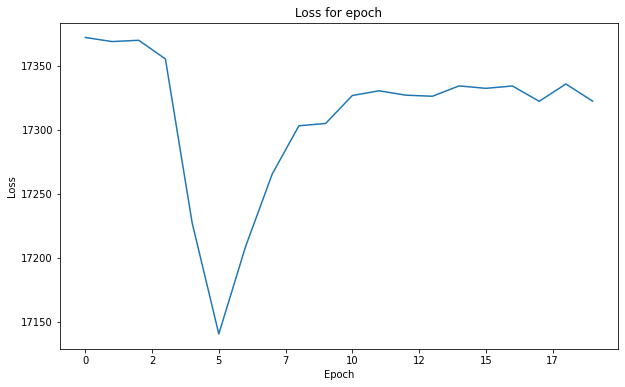

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
metrics_df = pd.DataFrame({'Loss' : gpt2_losses, 'Epoch' : [idx for idx in range(num_epochs)]})
axes.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
sns.lineplot(data=metrics_df, y='Loss', x='Epoch', ax=axes)
axes.set_title('Loss for epoch')

In [24]:
del trained_model
gc.collect()
torch.cuda.empty_cache()

# Own RNN-based network

In [13]:
cpu = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float32
max_len = 22

## Tokenizer

In [14]:
def get_vocabulary(df_data):
    vocab = set()
    for line in df_data['text']:
        words = wordpunct_tokenize(line)
        for word in words:
            if word.isdigit():
                continue
            word = ''.join(word.replace('\'', ''))
            if len(word) == 0:
                continue
            vocab.add(word)
    return vocab

class RnnTokenizer:
    def __init__(self):
        self.pad_word = '<pad>'
        self.pad_token = 0
    
    def _enumerate_internal(self, vocab):
        idx_shift = 1
        return {word : idx + idx_shift for idx, word in enumerate(vocab)}
    
    def set_vocabulary(self, vocab):
        self.vocab = vocab
        self.vocab.add(self.pad_word)
        self.word_to_token = self._enumerate_internal(vocab)
        self.word_to_token[self.pad_word] = self.pad_token
        self.token_to_word = {v : k for k, v in self.word_to_token.items()}
    
    def encode(self, sentence, max_len):
        words = wordpunct_tokenize(sentence)
        encoded = []
        idx = 0
        while idx < max_len:
            if idx >= len(words):
                word = self.pad_word
            else:
                word = words[idx]
            idx += 1
            word = ''.join(word.replace('\'', ''))
            if len(word) == 0:
                continue
            if word.isdigit():
                continue
            encoded.append(self.word_to_token[word])
        while len(encoded) < max_len:
            encoded.append(self.pad_token)
            idx += 1
        return encoded
    
    def decode(self, tokens):
        decoded = []
        for token in tokens:
            if token != self.pad_token:
                decoded.append(self.token_to_word[token])
        return ' '.join(decoded)
    
    

In [15]:
df_for_rnngen = df_text_data_red
vocab = get_vocabulary(df_for_rnngen)

In [16]:
print(len(vocab))

3346


In [17]:
df_for_rnngen.iloc[0].text

"but this year i went down to miami and got my nigga from 2 live brother marquis in the house! (yeah i'm."

In [18]:
tokenizer = RnnTokenizer()
tokenizer.set_vocabulary(vocab)

In [19]:
encoded = tokenizer.encode(df_for_rnngen.iloc[0].text, 50)
encoded

[2753,
 171,
 29,
 2759,
 1532,
 1398,
 3217,
 384,
 1695,
 3211,
 527,
 1287,
 292,
 824,
 2286,
 3073,
 2241,
 1576,
 37,
 2279,
 1217,
 1148,
 2759,
 3265,
 122,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [20]:
tokenizer.decode(encoded)

'but this year i went down to miami and got my nigga from live brother marquis in the house ! ( yeah i m .'

## Prepare dataset

In [21]:
data_list = []
for line in df_for_rnngen['text']:
    encoded = tokenizer.encode(line, max_len=max_len)
    data_list.append(encoded)
torch_dataset = torch.tensor(data_list, dtype=torch.long, device=cpu)

In [22]:
torch_dataset[2]

tensor([1715,  851, 2665,  924, 2475,  996, 2362, 1148, 1715,  725,  649, 2241,
        1576,   37, 3192, 1355, 2883, 3045,  122,    0,    0,    0])

## Let's define NN arch

In [23]:
class RnnTextGenerator(nn.Module):
    def __init__(self, tokenizer, device):
        super().__init__()
        self.embedding_dim = 128
        self.hidden_dim = 256
        self.num_layers = 3

        n_vocab = len(tokenizer.vocab)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.lstm = nn.LSTMCell(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_dim
        )
        self.fc1 = nn.Linear(self.hidden_dim, n_vocab // 2)
        self.fc2 = nn.Linear(n_vocab // 2, n_vocab)

    def forward(self, x):
        embed = self.embedding(x)
#         print('*', embed.shape)
        transrosed_embed = embed.transpose(0, 1)
        print('!', transrosed_embed.shape)
        hx, cx = self._init_state(embed.shape[0])
#         hx_storage = [hx]
        for words_batch in transrosed_embed:
#             print('words batch', words_batch.shape)
#             print('hx', hx.shape)
            hx, cx = self.lstm(words_batch, (hx, cx))
#             hx_storage.append(hx)
#         unpulled = torch.stack(hx_storage, dim=2)
#         pooled = self.maxpool(backward_pass).view(-1, self.hidden_dim)
        print('TO CHECK', )
#         print('#', output.shape, state.shape)
        output = self.fc1(hx)
        logits = self.fc2(output)
        print('LOGITS', logits.shape)
        return logits

    def _init_state(self, batch_size):
        return (torch.zeros(batch_size, self.hidden_dim, dtype=dtype, device=device),
                torch.zeros(batch_size, self.hidden_dim, dtype=dtype, device=device))

In [26]:
epoch_count = 50
rnn_model = RnnTextGenerator(tokenizer, device).to(device)
optimizer = AdamW(rnn_model.parameters(), lr=0.000001)
scheduler = ExponentialLR(optimizer, gamma=0.85)
criterion = CrossEntropyLoss()
batch_size = 16
for epoch in range(epoch_count):
    print(f'Epoch {epoch}/{epoch_count-1} started.')

    # Train loop
    perm_indices = list(BatchSampler(RandomSampler(range(torch_dataset.shape[0])), 
                                     batch_size=batch_size, drop_last=False))
    for batch_idx, batch_indices in enumerate(perm_indices):
        batch_data = torch_dataset[batch_indices].to(device)
        optimizer.zero_grad()
        print('BATCH DATA', batch_data.shape)
        predicted = rnn_model.forward(batch_data)
        loss = criterion(predicted, batch_data)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 10)
        optimizer.step()
        del batch_data, batch_labels, batch_extra, predicted, loss
        gc.collect()
        torch.cuda.empty_cache()
    scheduler.step()


Epoch 0/49 started.
BATCH DATA torch.Size([16, 22])
! torch.Size([22, 16, 128])
TO CHECK
LOGITS torch.Size([16, 3347])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported